In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

from skylark import skylark_root

In [3]:
# profiles/throughput.csv
df = pd.read_csv(skylark_root / "profiles" / "throughput.csv")
df["src_cloud"] = df.src_region.str.split(":").str[0]
df["dst_cloud"] = df.dst_region.str.split(":").str[0]
df["inter_cloud"] = df.src_cloud != df.dst_cloud
df

,src_region,src_tier,src_instance_class,dst_region,dst_tier,dst_instance_class,iperf3_connections,iperf3_runtime,tag,stdout_path,stderr_path,throughput_sent,throughput_received,cpu_utilization,success,src_cloud,dst_cloud,inter_cloud
0,aws:eu-west-3,PREMIUM,m5.8xlarge,gcp:europe-west6-a,STANDARD,n2-standard-32,64,5,aws:eu-west-3:PREMIUM_gcp:europe-west6-a:STANDARD,/home/ubuntu/skylark/data/logs/throughput_grid...,/home/ubuntu/skylark/data/logs/throughput_grid...,5.014191e+09,4.737424e+09,7.597162,True,aws,gcp,True
1,azure:germanywestcentral,PREMIUM,Standard_D32_v5,aws:eu-west-2,PREMIUM,m5.8xlarge,64,5,azure:germanywestcentral:PREMIUM_aws:eu-west-2...,/home/ubuntu/skylark/data/logs/throughput_grid...,/home/ubuntu/skylark/data/logs/throughput_grid...,9.681617e+09,9.374197e+09,14.788567,True,azure,aws,True
2,gcp:europe-central2-a,PREMIUM,n2-standard-32,gcp:europe-north1-a,PREMIUM,n2-standard-32,64,5,gcp:europe-central2-a:PREMIUM_gcp:europe-north...,/home/ubuntu/skylark/data/logs/throughput_grid...,/home/ubuntu/skylark/data/logs/throughput_grid...,6.889200e+09,6.785755e+09,80.358692,True,gcp,gcp,False
3,gcp:europe-west4-a,PREMIUM,n2-standard-32,azure:germanywestcentral,PREMIUM,Standard_D32_v5,64,5,gcp:europe-west4-a:PREMIUM_azure:germanywestce...,/home/ubuntu/skylark/data/logs/throughput_grid...,/home/ubuntu/skylark/data/logs/throughput_grid...,7.059707e+09,6.983349e+09,88.809888,True,gcp,azure,True
4,gcp:us-central1-a,STANDARD,n2-standard-32,gcp:us-east4-a,PREMIUM,n2-standard-32,64,5,gcp:us-central1-a:STANDARD_gcp:us-east4-a:PREMIUM,/home/ubuntu/skylark/data/logs/throughput_grid...,/home/ubuntu/skylark/data/logs/throughput_grid...,6.871022e+09,6.784220e+09,75.138341,True,gcp,gcp,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7048,aws:ap-northeast-1,PREMIUM,m5.8xlarge,gcp:europe-north1-a,STANDARD,n2-standard-32,64,5,aws:ap-northeast-1:PREMIUM_gcp:europe-north1-a...,/home/ubuntu/skylark/data/logs/throughput_grid...,/home/ubuntu/skylark/data/logs/throughput_grid...,5.292621e+09,2.843709e+09,4.542818,True,aws,gcp,True
7049,aws:ap-northeast-3,PREMIUM,m5.8xlarge,gcp:southamerica-east1-a,PREMIUM,n2-standard-32,64,5,aws:ap-northeast-3:PREMIUM_gcp:southamerica-ea...,/home/ubuntu/skylark/data/logs/throughput_grid...,/home/ubuntu/skylark/data/logs/throughput_grid...,5.096565e+09,2.802475e+09,4.695893,True,aws,gcp,True
7050,gcp:australia-southeast1-a,PREMIUM,n2-standard-32,gcp:europe-west1-b,PREMIUM,n2-standard-32,64,5,gcp:australia-southeast1-a:PREMIUM_gcp:europe-...,/home/ubuntu/skylark/data/logs/throughput_grid...,/home/ubuntu/skylark/data/logs/throughput_grid...,6.833454e+09,3.545164e+09,21.907525,True,gcp,gcp,False
7051,gcp:europe-west6-a,STANDARD,n2-standard-32,gcp:australia-southeast1-a,STANDARD,n2-standard-32,64,5,gcp:europe-west6-a:STANDARD_gcp:australia-sout...,/home/ubuntu/skylark/data/logs/throughput_grid...,/home/ubuntu/skylark/data/logs/throughput_grid...,6.397574e+09,3.471407e+09,21.140573,True,gcp,gcp,False


Text(0, 0.5, 'Throughput (Gbps)')

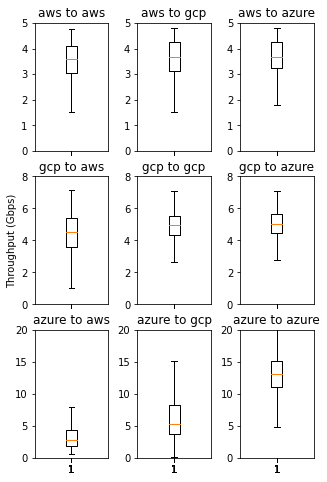

In [12]:
# plot 9 rows in one figure with one boxplot for each row
fig, ax = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(5, 8),
    sharex=True,
    # pad between rows
    gridspec_kw={"hspace": 0.2, "wspace": 0.4},
)
for i, src_cloud in enumerate(["aws", "gcp", "azure"]):
    for j, dst_cloud in enumerate(["aws", "gcp", "azure"]):
        idx = (i, j)
        ax[idx].boxplot(df[(df.src_cloud == src_cloud) & (df.dst_cloud == dst_cloud)].throughput_received / 1e9, showfliers=False)
        ax[idx].set_title(f"{src_cloud} to {dst_cloud}")
        # set scale to 0-12.5Gbps
        bw = [5, 8, 20]
        ax[idx].set_ylim(0, bw[i])
fig.patch.set_facecolor("white")
ax[1, 0].set_ylabel("Throughput (Gbps)")